In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import random
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

KeyboardInterrupt: 

In [ ]:
cwd = os.getcwd()

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in C:\Users\anton/.cache\torch\hub\pytorch_vision_v0.10.0
c:\DTU - KID\6. Semester\MIA_SD\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\DTU - KID\6. Semester\MIA_SD\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(torch. __version__)
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# Find out if a GPU is available
use_cuda = torch.cuda.is_available()
use_cuda

2.2.1+cu118
cuda


True

In [ ]:
images_folder = 'DTU_hwm_vs_AAU'


In [ ]:
root_im = cwd + os.sep + 'images_attack_model' + os.sep 

auxiliary_data = root_im  + images_folder + os.sep + '0' + os.sep
target_model_data = root_im  + images_folder + os.sep + '1' + os.sep

root_data = root_im + images_folder + os.sep
root_data_test =  root_im + 'DTU_hwm_vs_AAU_seen_test' + os.sep                               #'AAU_vs_lfw_test' + os.sep 


TypeError: can only concatenate str (not "list") to str

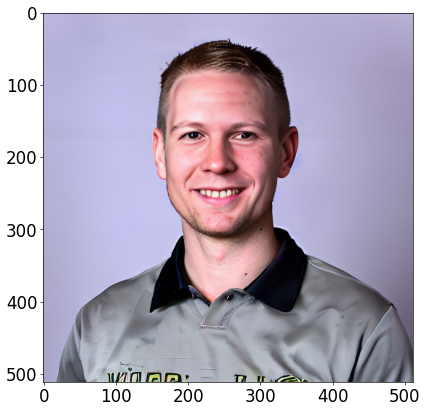

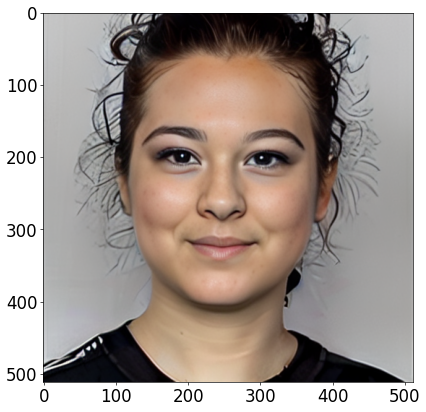

In [ ]:
# Display image for reference
img = Image.open(auxiliary_data + 'headshot-0-0.png')
plt.imshow(img)
plt.show()

img = Image.open(target_model_data + 'headshot-0-0.png')
plt.imshow(img)
plt.show()


In [ ]:
def create_dataset_train(parent_dir):
    # Define your transformations
    transform = transforms.Compose([
    transforms.Resize((224, 224)), # Standard is bilinear interpolation
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = datasets.ImageFolder(parent_dir, transform=transform)
    
    return dataset

# Create the Test Dataset. It is important to use the same transformations as the training dataset. 

def create_dataset_test(parent_dir):
    # Define your transformations
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    dataset = datasets.ImageFolder(parent_dir, transform=transform)
    
    return dataset


test_dataset = create_dataset_test(root_data_test)

test_dataset, val_set = torch.utils.data.random_split(test_dataset, [int(0.85*len(test_dataset)), int(0.15*len(test_dataset))])



In [ ]:
# Get the train_dataset
train_dataset = create_dataset_train(root_data)
# Get the validation_dataset
train_set, train_set_val = torch.utils.data.random_split(train_dataset, [int(1*len(train_dataset)), int(0*len(train_dataset))])


# Display the shape of the train_set, train_set_val, test_dataset and val_set
print(f'Train Set: {len(train_set)}')
print(f'Validation Set: {len(train_set_val)}')
print(f'Test Set: {len(test_dataset)}')
print(f'Validation Set: {len(val_set)}')



# make a dataLoader
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Train Set: 5000
Validation Set: 0
Test Set: 1904
Validation Set: 336


In [ ]:
class_names = train_dataset.classes
print('Class names:', class_names)

Class names: ['0', '1']


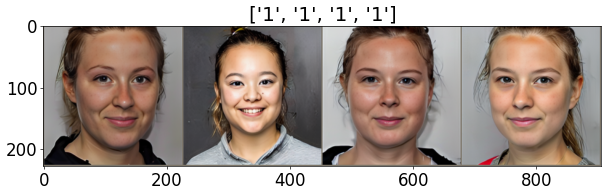

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [ ]:
num_features = model.fc.in_features 
print('Number of features from pre-trained model', num_features)

# # Freeze all the layers except the final layer
# for param in model.parameters():
#     param.requires_grad = False

# Add a fully-connected layer for classification
model.fc = nn.Linear(num_features, 2)

# Display the model architecture

print(model)


model = model.to(device)

Number of features from pre-trained model 512
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Set the random seeds
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

In [ ]:
#### Train model
train_loss = []
train_accuary = []
val_loss = []
val_accuary = []

num_epochs = 20
start_time = time.time() 


for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_set)
    epoch_acc = running_corrects / len(train_set) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))

    """ Validation Phase """
    model.eval()    #(evaluation model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(val_set)
    epoch_acc = running_corrects / len(val_set) * 100.
    # Append result
    val_loss.append(epoch_loss)
    val_accuary.append(epoch_acc)
    # Print progress
    print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))



Epoch 0 running
[Train #1] Loss: 0.0011 Acc: 98.5600% Time: 163.2155s
[Validation #1] Loss: 0.0405 Acc: 66.0714% Time: 171.4135s
Epoch 1 running
[Train #2] Loss: 0.0005 Acc: 99.4200% Time: 294.4315s
[Validation #2] Loss: 0.0348 Acc: 75.2976% Time: 300.9555s
Epoch 2 running
[Train #3] Loss: 0.0002 Acc: 99.9000% Time: 429.7896s
[Validation #3] Loss: 0.0534 Acc: 61.9048% Time: 437.1476s
Epoch 3 running
[Train #4] Loss: 0.0001 Acc: 99.9400% Time: 570.1796s
[Validation #4] Loss: 0.0881 Acc: 55.9524% Time: 577.0506s
Epoch 4 running
[Train #5] Loss: 0.0000 Acc: 99.9800% Time: 710.2629s
[Validation #5] Loss: 0.0606 Acc: 65.1786% Time: 717.3949s
Epoch 5 running
[Train #6] Loss: 0.0002 Acc: 99.7600% Time: 849.9369s
[Validation #6] Loss: 0.0535 Acc: 61.9048% Time: 857.6028s
Epoch 6 running
[Train #7] Loss: 0.0003 Acc: 99.6400% Time: 991.7662s
[Validation #7] Loss: 0.0871 Acc: 55.0595% Time: 998.4921s
Epoch 7 running
[Train #8] Loss: 0.0005 Acc: 99.4000% Time: 1133.3434s
[Validation #8] Loss: 0.05

In [ ]:
save_path = 'images_attack_model' + os.sep + images_folder + os.sep + 'custom-classifier_resnet_18_final.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
# Get model
save_path = 'images_attack_model' + os.sep + images_folder + os.sep + 'custom-classifier_resnet_18_final.pth'
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

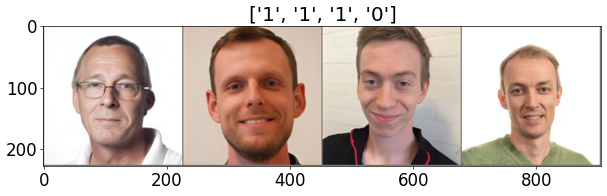

In [ ]:
# Print some images from the test dataset
iterator = iter(test_dataloader)
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
# If class name SD15_v1 is DTU and aau is auxiliary
imshow(out, title=[class_names[x] for x in classes[:4]])

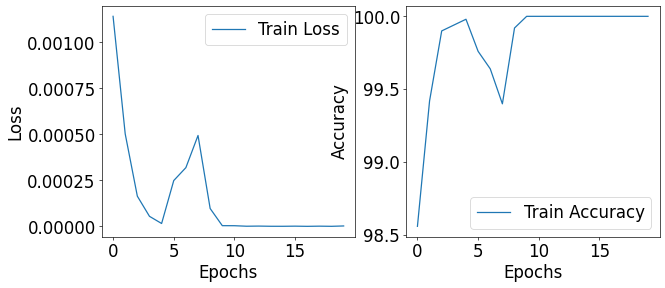

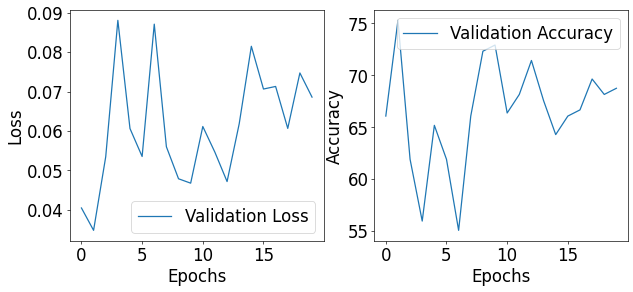

In [ ]:
# Visualize the training process on two plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuary, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize the validation process on two plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accuary, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


              precision    recall  f1-score   support

           0       0.65      0.96      0.77       962
           1       0.91      0.47      0.62       942

    accuracy                           0.72      1904
   macro avg       0.78      0.71      0.70      1904
weighted avg       0.78      0.72      0.70      1904



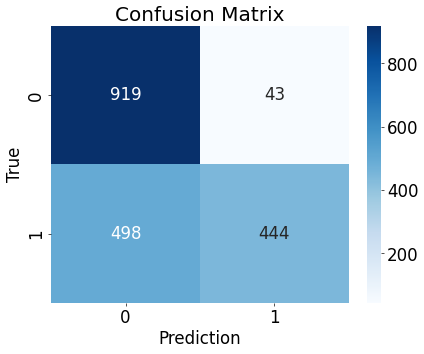

In [ ]:
# Visualize the test with metrics and confusion matrix
from sklearn.metrics import classification_report
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        # Get the probability of the positive class
        y_pred += probs[:, 1].tolist()
        y_true += labels.tolist()
print(classification_report(y_true, np.array(y_pred) > 0.5, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, np.array(y_pred) > 0.5)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



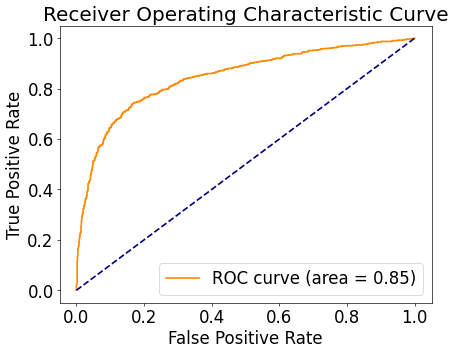

0.8458459684574334

In [ ]:
# Show the auc score and the roc curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr,tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

roc_auc_score(y_true, y_pred)


Threshold value is: 0.0015746820718050003


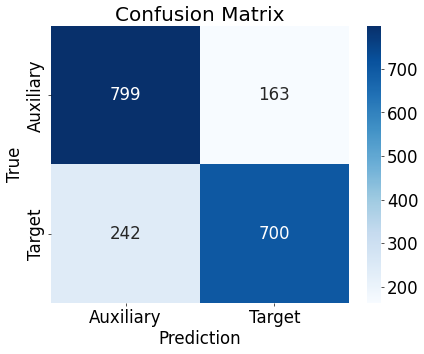

: 

In [ ]:
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

cm = confusion_matrix(y_true, np.array(y_pred) > optimal_threshold)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Auxiliary', 'Target'], yticklabels=['Auxiliary', 'Target'], cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()